In [3]:

import json, nltk, re, os, codecs

import pandas as pd
from pandas.io.json import json_normalize
#import pandas_profiling
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
import altair as alt
alt.renderers.enable("notebook")

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn import feature_extraction

from pymongo import MongoClient


In [7]:
def connect():
    connection = MongoClient('10.10.250.0', 27017)
    handle = connection["projectfinder"]
    return handle
db = connect()


In [8]:
def load_data_from_momgodb():
    exclude_data = {'_id': False}
    raw_data = list(db.itproject_clean.find({}, projection=exclude_data))
    dataset = pd.DataFrame(raw_data)
    return dataset

In [9]:
def load_data_from_json(data):
    with open(data) as f:
            d = json.load(f)
        #normalize json
    dataset= json_normalize(d)
    return dataset

In [10]:
def clean_dataset(data):
    #select colunms
    df = data[['title', 'description', 'bereich']]
    df = df[df['description'] != '']
   
    df['project'] = df['title'] + '/' + df['description']
    df['label'] = df['bereich']
    df.drop(['title', 'description', 'bereich'], axis=1, inplace=True)
    df = df[df['label'] != 'IT/Bauingenieur']
    df = df.drop_duplicates()
    return df

In [17]:
data = load_data_from_momgodb()
df = clean_dataset(data)
df.head()

,project,label
0,IT Berater (m/w) für bankfachliche Anwendungen...,IT/Admin-Microsoft
1,Hier nicht mehr aktiv/Kann Profil leider nicht...,SW/Dev-Web-Backend
2,Business Intelligence Analyst (m/w) - Tableau ...,DS-BI
3,Developer - Talend ESB oder Apache Camel (m/w)...,SW/Dev-Web-Backend
4,Erstellung von Automatisierungen mit ubot stud...,IT/IT


In [12]:
df.shape

(12400, 2)

In [149]:
df.shape[0]

12400

In [18]:
df['label'].replace(['IT/Admin-Oracle'], 'IT/Admin-Database', inplace=True)
df['label'].replace(['IT/SAP'], 'ERP-SAP', inplace=True)
df['label'].replace(['DS-ML','DS-BI', 'IT/Business Int'], 'D_Science/Analysis', inplace=True)
df['label'].replace(['IT-Admin-Linux'], 'IT/Admin-Linux', inplace=True)
df['label'].replace(['IT/Management (','IT/Projektleitu','IT/Fertigungste'], 'IT/Project Mgmt', inplace=True)
df['label'].replace(['SW/Tester','IT/Softwareentw','IT/Qualitätsman','IT/Weitere IT-Q'], 'SW/Dev-Web-Fullstack', inplace=True)
df['label'].replace(['IT/Automatisier','IT/Software Arc'], 'SW/Dev-Devops', inplace=True)
df['label'].replace(['IT/Admin-CITRIX','IT/Admin-ITIL', 'IT/Admin-Netwerk-Cisco'], 'IT/Admin-Others', inplace=True)
df['label'].replace(['IT/Maschinen- /','IT/Konstruktion', 'IT/Mess- / Rege', 'IT/Fahrzeugbau', 'IT/Hardware-Ent', 'IT/Engineering', 'IT/Elektrotechn', 'IT/Technisches '], 'IT/Technisches', inplace=True)

In [19]:
df = df.apply(lambda x: x.mask(x.map(x.value_counts())<90, 'other') if x.name!='project' else x)

In [20]:
df.head(10)

,project,label
0,IT Berater (m/w) für bankfachliche Anwendungen...,IT/Admin-Microsoft
1,Hier nicht mehr aktiv/Kann Profil leider nicht...,SW/Dev-Web-Backend
2,Business Intelligence Analyst (m/w) - Tableau ...,D_Science/Analysis
3,Developer - Talend ESB oder Apache Camel (m/w)...,SW/Dev-Web-Backend
4,Erstellung von Automatisierungen mit ubot stud...,other
5,Spieleentwickler mit Hardwarekenntnissen/Unser...,SW/Dev-Web
6,"221380, Bilanzbuchhalter (m/w)/Future Consulti...",SW/Dev-Web-Backend
7,IT-Mitarbeiter (m/w) 1st / 2nd Level Support /...,IT/Admin-Microsoft
8,Consultant für Microsoft Dynamics CRM (m/w)/Üb...,IT/Admin-Microsoft
9,Java Senior Developer - Backend (f/m)/Über uns...,SW/Dev-Web-Fullstack


In [21]:
df['label'].value_counts()


SW/Dev-Web              1576
IT/Consulting           1515
ERP-SAP                 1440
SW/Dev-Web-Fullstack    1398
IT/Admin-Microsoft      1292
IT/Project Mgmt         1038
other                    800
Big Data-Data Engr       753
IT/Admin-Database        466
IT/Admin-Linux           433
IT/Admin-Others          382
SW/Dev-Web-Backend       371
SW/Dev-Devops            274
IT/Technisches           235
SW/Dev-Mobile            227
D_Science/Analysis       200
Name: label, dtype: int64

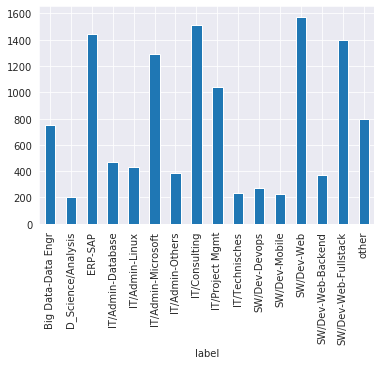

In [22]:
df.groupby('label').size().plot(kind='bar')

In [23]:
categories = pd.get_dummies(df['label'])
df_new = pd.concat([df, categories], axis=1)
df_new.head()

,project,label,Big Data-Data Engr,D_Science/Analysis,ERP-SAP,IT/Admin-Database,IT/Admin-Linux,IT/Admin-Microsoft,IT/Admin-Others,IT/Consulting,IT/Project Mgmt,IT/Technisches,SW/Dev-Devops,SW/Dev-Mobile,SW/Dev-Web,SW/Dev-Web-Backend,SW/Dev-Web-Fullstack,other
0,IT Berater (m/w) für bankfachliche Anwendungen...,IT/Admin-Microsoft,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Hier nicht mehr aktiv/Kann Profil leider nicht...,SW/Dev-Web-Backend,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,Business Intelligence Analyst (m/w) - Tableau ...,D_Science/Analysis,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Developer - Talend ESB oder Apache Camel (m/w)...,SW/Dev-Web-Backend,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Erstellung von Automatisierungen mit ubot stud...,other,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [24]:
# drop the original categories column from `df`
df_new = df_new.drop('label',axis=1)
df_new.head()

,project,Big Data-Data Engr,D_Science/Analysis,ERP-SAP,IT/Admin-Database,IT/Admin-Linux,IT/Admin-Microsoft,IT/Admin-Others,IT/Consulting,IT/Project Mgmt,IT/Technisches,SW/Dev-Devops,SW/Dev-Mobile,SW/Dev-Web,SW/Dev-Web-Backend,SW/Dev-Web-Fullstack,other
0,IT Berater (m/w) für bankfachliche Anwendungen...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Hier nicht mehr aktiv/Kann Profil leider nicht...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,Business Intelligence Analyst (m/w) - Tableau ...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Developer - Talend ESB oder Apache Camel (m/w)...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Erstellung von Automatisierungen mit ubot stud...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [41]:
import pickle
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, LSTM, GRU
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path
from keras.layers.embeddings import Embedding

In [33]:
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [65]:
X = df['project']
y = df['label']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)